# COMP9417 19T3  Homework 2: Applying and Implementing Machine Learning

# Question 1

## Question 1 – Learning curve 

The number of data instances required to effectively learn the target function depends on dataset characteristics and the learning algorithm. In this question, you will interpret results of learning three different datasets by two machine learning algorithms trained on varying size of data, from 5% to 90% of the dataset. After training on a fraction of the dataset, the model is tested using the rest of the dataset. For example, if 40% of data is used for training, the remaining 60% of the dataset is used for testing the trained model.
The datasets are from different, real-world  domains, and vary in size from a few hundred to a couple of thousand instances. For a smoother learning curve, the training is done in a cross validation fashion.


### Running the classifiers

**1(a). [0.5 mark]** 

Run the code section in the notebook cells below. This will generate a table of results, which you should copy and paste **WITHOUT MODIFICATION** into you report as your answer for "Question 1(a)". 

The output of the code section is a table, which represents the percentage accuracy of classification for the decision tree algorithm. Each of the columns shows accuracy for a model trained on a different fraction of the dataset.

### Result interpretation
Answer these questions in your report file.  Your answers must be based on the results table you saved in "Question 1(a)".

**1(b). [0.5 mark]** Refer to Homework2.pdf file.

**1(c). [0.5 mark]** Refer to Homework2.pdf file.

In [73]:
# Code for question 1

import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline


In [74]:
# fixed random seed
np.random.seed(1)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def label_enc(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    return le

In [75]:
def load_data(path):
    dataset = arff.loadarff(path)
    data = pd.DataFrame(dataset[0])
    attr = np.array(data.columns)
    data = DataFrameImputer().fit_transform(data).values

    # mask categorical features
    masks = []
    for i in range(len(attr)-1):
        if isinstance(attr[i][1],float):
            masks.append(i)
    return data, masks

class DataFrameImputer(TransformerMixin):

    def fit(self, X, y=None):
        # Fill categorical columns with the highest frequency value, and
        # fill values columns with mean
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

def get_method_scores(data, method):
    X = data[:,0:data.shape[1]-1]
    lenc = label_enc(data[:,data.shape[1]-1])
    y = lenc.transform(data[:,data.shape[1]-1])
    train_sizes = np.array([0.05, .1, .15, .2, .25, .3, .35, .4, .45, .5])
    _, train_scores, test_scores = learning_curve(method, X, y, cv=5, 
                                                  train_sizes=train_sizes,
                                                  scoring=None, shuffle=False, random_state=0, 
                                                  error_score=0)
    return test_scores

In [76]:
# Modified to return the scores list
def test_method(method, title):
    # load data
    paths = ['australian','balance-scale','hypothyroid']
    scores = []

    for path in paths:
        score = []
        path += '.arff'
        data, masks = load_data(path)

        # training on data with different portions of training data
        score_array = get_method_scores(data, method)
        # we got a [num portions][num folds] array, need to avg them into 
        # a list of scores for each portion
        for ar in score_array:
            score.append(np.mean(ar)) # because we use 5-fold cross validation (cv=5)
        scores.append(score)

    # print the results
    method_name = method.__class__.__name__+' '+title
    header = "{:^75}".format(method_name) + '\n' + '-' * 105  + '\n' + \
    "{:^13} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} |" \
    .format("Dataset", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%", "45%", "50%") + \
     '\n' + '-' * 105

    # print result table
    print(header)
    for i in range(len(scores)):
        print("{:<14}".format(paths[i]),end="")
        for j in range(len(scores[i])):
            print("| {:>6.2%} ".format(scores[i][j]),end="")
        print('|')
    print('\n')
    return scores

dt_scores=test_method(DecisionTreeClassifier(random_state=0),'')
ber_scores=test_method(BernoulliNB(),'with priors')

                          DecisionTreeClassifier                           
---------------------------------------------------------------------------------------------------------
   Dataset    |   5%   |  10%   |  15%   |  20%   |  25%   |  30%   |  35%   |  40%   |  45%   |  50%   |
---------------------------------------------------------------------------------------------------------
australian    | 72.61% | 74.63% | 75.52% | 77.53% | 77.97% | 79.86% | 83.05% | 81.29% | 80.14% | 82.91% |
balance-scale | 70.10% | 72.47% | 71.20% | 75.69% | 73.77% | 75.67% | 77.74% | 75.99% | 78.09% | 76.98% |
hypothyroid   | 94.94% | 96.31% | 97.77% | 99.18% | 99.21% | 99.42% | 99.42% | 99.52% | 99.34% | 99.20% |


                          BernoulliNB with priors                          
---------------------------------------------------------------------------------------------------------
   Dataset    |   5%   |  10%   |  15%   |  20%   |  25%   |  30%   |  35%   |  40%   |  45%   |  50%   

In [77]:
ber_no_prior_scores = test_method(BernoulliNB(fit_prior=False),'without priors')

                        BernoulliNB without priors                         
---------------------------------------------------------------------------------------------------------
   Dataset    |   5%   |  10%   |  15%   |  20%   |  25%   |  30%   |  35%   |  40%   |  45%   |  50%   |
---------------------------------------------------------------------------------------------------------
australian    | 73.62% | 79.27% | 81.44% | 78.98% | 78.40% | 79.69% | 78.52% | 79.83% | 80.41% | 80.41% |
balance-scale | 46.08% | 46.08% | 46.08% | 46.08% | 46.08% | 46.08% | 46.08% | 46.08% | 46.08% | 46.08% |
hypothyroid   | 83.88% | 79.59% | 77.44% | 74.79% | 73.12% | 65.05% | 53.60% | 51.30% | 51.09% | 50.26% |




### Part B in the question

Looking at the results for BOTH the Bernoulli Naive Bayes and Decision Tree learning models over all the datasets, the following is true regarding a possible "learning curve" effect due to increasing the size of the training set (choose ALL true statements):<br>
--- (1) none of the 6 models show a learning curve<br>
--- (2) all of the 6 models show a learning curve<br>
--- (3) most of the 6 models show a learning curve<br>
--- (4) All 3 Decision Tree models are generally better than Bernoulli Naive Bayes models<br>
--- (5) Some Bernoulli Naive Bayes models are better than Decision Tree models

In [78]:
# Compare two test_score list data by plotting
def plot_cmp(scores1,scores2,label1,label2):
    paths = ['australian','balance-scale','hypothyroid']
    if(len(scores1)==0 or len(scores2)==0):
        raise ValueError('plot_all():The input list is empty')
    x_axis = np.arange(0.05,0.55,0.05)
    for i in range(len(paths)):
        plt.figure()
        plt.gca().xaxis.set_major_formatter(PercentFormatter(1)) # Set axis to be in percentage format
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.style.use('ggplot')
        plt.plot(x_axis,scores1[i],marker='o',color='blue',label=label1)
        plt.plot(x_axis,scores2[i],marker='o',color='red',label=label2)
        plt.xticks(np.arange(0.05,0.55,0.05))
        plt.yticks(np.arange(0,1.2,step=0.1))
        plt.legend()
        plt.xlabel('Training Size')
        plt.ylabel('Accuracy')
        plt.title('Learning Curve for {0}'.format(paths[i].title()))
        plt.savefig('{0}.png'.format(paths[i]),dpi=1000)
        plt.show()

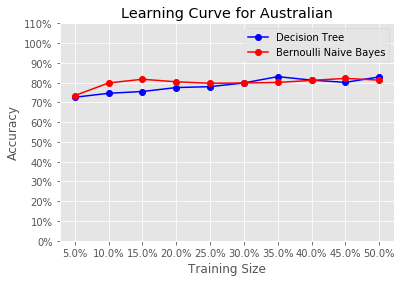

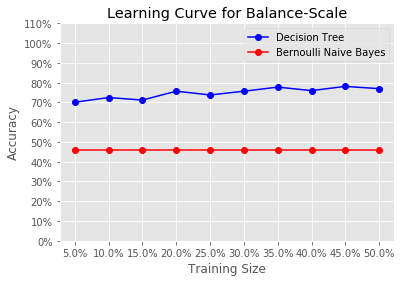

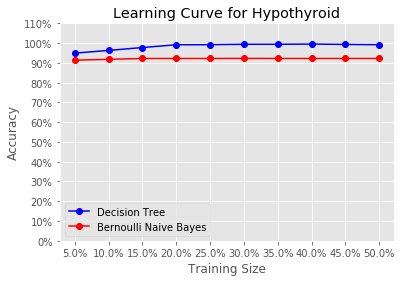

In [79]:
plot_cmp(dt_scores,ber_scores,'Decision Tree','Bernoulli Naive Bayes')

### Part C in the question

Bernoulli Naive Bayes (BNB) in the code used in the previous question use class priors as a default. In some cases better results can be obtained without using priors.
In this question you will find how the results are affected by removing class priors (in this case replacing them with uniform probabilities). After the last line, add one more line of code for BNB but with uniform priors and re-run the code. Consult sklearn documentation which option to use.
After adding the new line, compare BNB model results with and without priors and choose ONE true statement from the below:<br>
--- (1) BNB preforms better with priors<br>
--- (2) BNB preforms better without priors<br>
--- (3) there is no difference in performance when using BNB with or without priors<br>

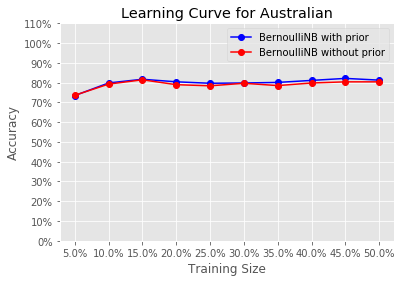

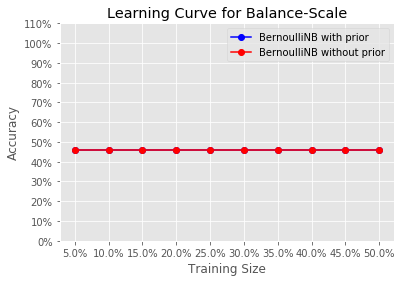

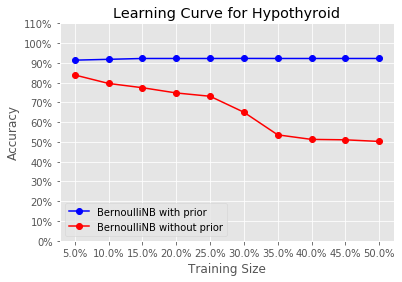

In [80]:
plot_cmp(ber_scores,ber_no_prior_scores,'BernoulliNB with prior','BernoulliNB without prior')

#### Grid Search Cross Validation

Now we use GridSearchCV() function in **sklearn** package to compare the BNB models with priors and without priors.

In [81]:
# Grid Search Cross Validation Part
fit_prior = [True,False]
param_grid = dict(fit_prior=fit_prior)
grid_search = GridSearchCV(BernoulliNB(),param_grid,n_jobs=-1,cv=5)
paths = ['australian','balance-scale','hypothyroid']
for path in paths:
    path += '.arff'
    data, masks = load_data(path)
    # We treat the whole file data as the training set
    train_x = data[:,0:data.shape[1]-1]
    lenc = label_enc(data[:,data.shape[1]-1])
    train_y = lenc.transform(data[:,data.shape[1]-1])
    grid_result = grid_search.fit(train_x,train_y)
    print("In data {0}, the best prior is {1}, with grid score {2}".\
         format(path,grid_result.best_params_,grid_result.best_score_))

In data australian.arff, the best prior is {'fit_prior': True}, with grid score 0.827536231884058
In data balance-scale.arff, the best prior is {'fit_prior': True}, with grid score 0.4608
In data hypothyroid.arff, the best prior is {'fit_prior': True}, with grid score 0.922322375397667


Therefore, BNB model with priors performs better.

# Question 2

## Question 2- Decision Tree

In this practical question, you will develop a machine learning model using Decision Tree to predict which passenger will survive the Titanic sinking. You will also calculate some probabilities based on your knowledge from lectures and tutorials. In order to do this, you will use “titanic.csv” file with 887 instances. For easy pre-processing, the column values are coded as integers with the following meaning:<br>
'Pclass': passenger class: 1, 2 or 3<br>
'Sex': 0 male, 1 female<br>
'Age': 0: 0-9 years old, 10: 10-19 years old, and so on<br>
'Siblings_Spouses_Aboard': number of siblings and/or spouses traveling with a passenger <br>
'Parents_Children_Aboard': number of parents (if the passenger is a child) or number children (if the passenger is a parent)<br>
'Survived': 0 did not survived, 1 survived<br>
Then you should be able to find the answer for the questions.

#### Pre-processing

In [82]:
TEST_SIZE=0.3
data = pd.read_csv('titanic.csv')
print(data.head(5))
print(data.isnull().sum()) #check whether there are null value data

   Pclass  Sex  Age  Siblings_Spouses_Aboard  Parents_Children_Aboard  \
0       3    1   20                        1                        0   
1       1    0   30                        1                        0   
2       3    0   20                        0                        0   
3       1    0   30                        1                        0   
4       3    1   30                        0                        0   

   Survived  
0         0  
1         1  
2         1  
3         1  
4         0  
Pclass                     0
Sex                        0
Age                        0
Siblings_Spouses_Aboard    0
Parents_Children_Aboard    0
Survived                   0
dtype: int64


From the result above, there is no <b><i>null</i></b> values in the dataset.

In [83]:
#Apply min-max normalisation
cols = data.columns
np_scaled = preprocessing.MinMaxScaler().fit_transform(data)
data = pd.DataFrame(np_scaled,columns=cols)

In [84]:
# Split training set and test set
data_x = data.iloc[:,:-1]
data_y = data.iloc[:,-1]
train_x,test_x,train_y,test_y= train_test_split(data_x,data_y,test_size=TEST_SIZE,shuffle=False)

#### Part A 

Implement a Decision Tree Classifier for survival prediction using sklearn library with all other parameters left default. What is your accuracy score for training and test dataset?

In [85]:
clf = DecisionTreeClassifier().fit(train_x,train_y)
print('The accuracy score for training set is',accuracy_score(train_y,clf.predict(train_x)))
print('The accuracy score for test set is',accuracy_score(test_y,clf.predict(test_x)))

The accuracy score for training set is 0.8564516129032258
The accuracy score for test set is 0.8277153558052435


#### Part B

Find an optimal number of min_samples_leaf by developing a search algorithm to search min_samples_leaf between 2 and 20. Please use AUC score in the search.

In [86]:
AUC_scores_train=[]
AUC_scores_test=[]
for i in range(2,21):
    clf = DecisionTreeClassifier(min_samples_leaf=i).fit(train_x,train_y)
    AUC_scores_train.append([i,roc_auc_score(train_y,clf.predict_proba(train_x)[:,1])])
    AUC_scores_test.append([i,roc_auc_score(test_y,clf.predict_proba(test_x)[:,1])])
sorted_train_AUC = sorted(AUC_scores_train,reverse=True,key=lambda x:x[1])
sorted_test_AUC = sorted(AUC_scores_test,reverse=True,key=lambda x:x[1])
print('For training set, the optimal number of min_samples_leaf is {0:0}, with AUC score {1:.5}'\
     .format(sorted_train_AUC[0][0],sorted_train_AUC[0][1]))
print('For test set, the optimal number of min_samples_leaf is {0:0}, with AUC score {1:.5}'\
     .format(sorted_test_AUC[0][0],sorted_test_AUC[0][1]))

For training set, the optimal number of min_samples_leaf is 2, with AUC score 0.91383
For test set, the optimal number of min_samples_leaf is 5, with AUC score 0.88889


#### Part C

Plot the AUC score for all iterations (k: 2,...,20) in training and test sets. (one plot for training, and one for test set).

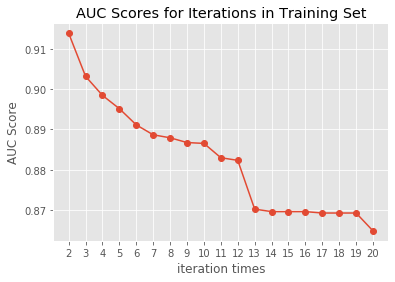

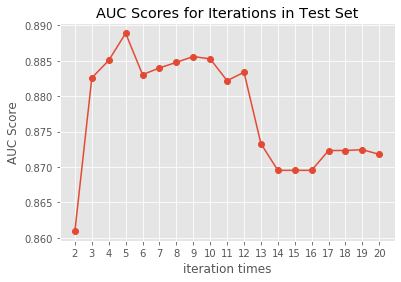

In [87]:
def plot_AUC(AUC_score,title):
    x_axis = np.arange(2,21).astype(int)
    plt.figure()
    plt.style.use('ggplot')
    plt.plot(x_axis,[y[1] for y in AUC_score],marker='o')
    plt.xticks(np.arange(2,21,step=1))
    plt.xlabel('iteration times')
    plt.ylabel('AUC Score')
    plt.title('AUC Scores for Iterations in {0} Set'.format(title.title()))
    plt.savefig('{0}.png'.format(title.title()),dpi=1000)
    plt.show()
        
plot_AUC(AUC_scores_train,'training')
plot_AUC(AUC_scores_test,'test')

#### Part D

Using the same titanic dataset, calculate the posterior probability that a female passenger, who travels in the first class, survives. Use full titanic dataset to calculate this probability.<br>
P(S= true | G=female,C=1)

We know that $$P(S=true|G=female,C=1)=\frac{P(S=true,G=female,C=1)}{P(G=female,C=1)}$$

In [88]:
#reload data
data = pd.read_csv('titanic.csv')

In [89]:
numerator = len(data[(data.Survived==1)&(data.Sex==1)&(data.Pclass==1)])/len(data)
denominator = len(data[(data.Sex==1)&(data.Pclass==1)])/len(data)
print('The numerator is {0}, the denominator is {1}'.format(numerator,denominator))
print('The probability is',numerator/denominator)

The numerator is 0.05073280721533258, the denominator is 0.1375422773393461
The probability is 0.36885245901639346
